In [3]:
import fiftyone as fo
import pandas as pd
import os
import glob
from tqdm import tqdm
import timm
import torch
import torch.nn as nn
import numpy as np
import cv2
import pickle

resize = 32
ds_root = os.path.join(os.environ["DATASET_ROOT"], "bcd2022")
image_root = os.path.join(ds_root, "patch_128_fold_0")
image_root

'/media/alenic/SecondM2/dataset/bcd2022/patch_128_fold_0'

In [4]:
fo.list_datasets()

[]

In [5]:
try:
    dataset = fo.Dataset("bcd2022_moco", overwrite=True)
except ValueError as e:
    dataset = fo.load_dataset("bcd2022_moco")
    # overwrite=True force the overvwrite
    print(e)

In [6]:
dataset

Name:        bcd2022_moco
Media type:  None
Num samples: 0
Persistent:  False
Tags:        []
Sample fields:
    id:       fiftyone.core.fields.ObjectIdField
    filepath: fiftyone.core.fields.StringField
    tags:     fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)

In [7]:
paths = glob.glob(os.path.join(image_root, "0", "*.png"))
for path in tqdm(paths):
    sample = fo.Sample(filepath=path)
    dataset.add_sample(sample)

100%|███████████████████████████████████| 93973/93973 [00:34<00:00, 2750.52it/s]


# Embeddings

In [8]:
# Do Only the first time (Save as emb.npy)
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A

device = "cuda:0"

class DatasetInf:
    def __init__(self, path):
        self.path = path
    def __len__(self):
        return len(self.path)
    def __getitem__(self, index):
        img = cv2.imread(self.path[index], 0)
        img = A.Compose([A.Resize(width=resize, height=resize), A.ToFloat(), ToTensorV2()])(image=img)["image"]
        return img


d = DatasetInf(paths)
loader = torch.utils.data.DataLoader(d, num_workers=8, batch_size=128)


In [9]:


def load_state_dict_improved(state_dict, model: nn.Module, replace_str=None, prepend=None):
    model_state_dict = model.state_dict()
    ckpt_state_dict = {}

    for key in state_dict:
        keyr = key
        if replace_str is not None:
            keyr = keyr.replace(replace_str[0], replace_str[1])
        if prepend is not None:
            keyr = prepend + keyr
        ckpt_state_dict[keyr] = state_dict[key]
    

    n_load = 0
    for key in model_state_dict:
        if key in ckpt_state_dict.keys():
            model_state_dict[key] = ckpt_state_dict[key]
            n_load += 1
        else:
            print(f"model {key} is not in checkpoint")

    for key in ckpt_state_dict:
        if key not in model_state_dict.keys():
            print(f"checkpoint {key} is not in model")
    
    return model.load_state_dict(model_state_dict)

In [10]:


model = timm.create_model("tf_efficientnetv2_s_in21ft1k", in_chans=1, pretrained=False, num_classes=0)
print(load_state_dict_improved(torch.load("output_moco/tf_efficientnetv2_s_in21ft1k/moco_0039.pth"), model))
model.eval()
model.to(device)
emb = []
for k, img in enumerate(tqdm(loader)):
    with torch.no_grad():
        output = model(img.to(device))
    emb += [output.cpu().numpy()]

emb = np.vstack(emb)
np.save("emb", emb)
print(emb.shape)

checkpoint classifier.weight is not in model
checkpoint classifier.bias is not in model
<All keys matched successfully>


100%|█████████████████████████████████████████| 735/735 [00:15<00:00, 46.09it/s]


(93973, 1280)


In [ ]:
import fiftyone.brain as fob
emb = np.load("emb.npy")

# Compute 2D representation
results = fob.compute_visualization(
    dataset,
    embeddings=emb,
    num_dims=2,
    method="umap",
    brain_key="mnist_test",
    verbose=True,
    seed=51,
)

Generating visualization...
UMAP(random_state=51, verbose=True)
Mon Jan  9 02:21:25 2023 Construct fuzzy simplicial set
Mon Jan  9 02:21:25 2023 Finding Nearest Neighbors
Mon Jan  9 02:21:25 2023 Building RP forest with 20 trees
Mon Jan  9 02:21:31 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	Stopping threshold met -- exiting after 3 iterations
Mon Jan  9 02:21:42 2023 Finished Nearest Neighbor Search
Mon Jan  9 02:21:44 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

# Launch Session

In [ ]:
fo.config.default_app_port

In [ ]:
session = fo.launch_app(dataset)

plot = results.visualize()
plot.show(width=720)

session.plots.attach(plot)


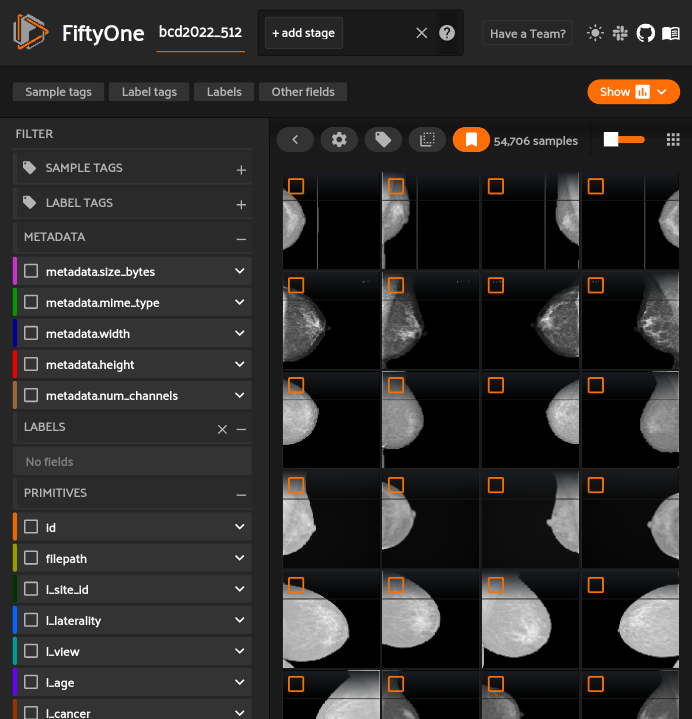